# Baseline

In [10]:
import pandas as pd 
import os
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from data.CICIDS2017.cicids2017_cleaning import load_and_clean

In [2]:
full_df = load_and_clean()

Total files: 8
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Monday-WorkingHours.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading: C:\Users\Rasmus\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1\Tuesday-Worki

In [3]:
# Filter dataset
attack_labels = ['DoS Hulk']
all_labels = ['BENIGN'] + attack_labels

filtered_df = full_df[full_df['Label'].isin(all_labels)].copy()

print("Class distribution after filtering:")
print(filtered_df['Label'].value_counts())

Class distribution after filtering:
Label
BENIGN      2095057
DoS Hulk     172846
PortScan      90694
Name: count, dtype: int64


In [20]:
X_full = filtered_df.drop('Label', axis=1)
y_full = filtered_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    stratify=y_full,
    test_size=0.3,
    random_state=42
)

print("Train label distribution (before balancing):")
print(y_train.value_counts())

Train label distribution (before balancing):
Label
BENIGN      1466539
DoS Hulk     120992
PortScan      63486
Name: count, dtype: int64


In [21]:
# Balance ONLY the training set (downsample the majority class to match the minority)
train_df = X_train.copy()
train_df['Label'] = y_train.values

counts = train_df['Label'].value_counts()
attack_min_counts = counts.min()

attack_df = train_df[train_df['Label'].isin(attack_labels)]
benign_sampled_df = train_df[train_df['Label'] == 'BENIGN'].sample(n=attack_min_counts, random_state=42)

balanced_train_df = pd.concat([attack_df, benign_sampled_df], ignore_index=True).sample(frac=1, random_state=42)

In [22]:
X_train_balanced = balanced_train_df.drop('Label', axis=1)
y_train_balanced = balanced_train_df['Label']

print("X_train_balanced shape:", X_train_balanced.shape)
print("y_train_balanced distribution:")
print(y_train_balanced.value_counts())

X_train_balanced shape: (1651017, 76)
y_train_balanced distribution:
Label
BENIGN      1466539
DoS Hulk     120992
PortScan      63486
Name: count, dtype: int64


In [23]:
os.makedirs('models', exist_ok=True)

total_trees = 100
step = 10

clf = RandomForestClassifier(n_estimators=step, warm_start=True, n_jobs=-1, random_state=42)
start = time.time()
for n in range(step, total_trees + 1, step):
    clf.set_params(n_estimators=n)
    clf.fit(X_train_balanced, y_train_balanced)
    elapsed = time.time() - start
    print(f"Trained {n}/{total_trees} trees ({n/total_trees*100:.1f}%), elapsed {elapsed:.1f}s")

Trained 10/100 trees (10.0%), elapsed 15.3s
Trained 20/100 trees (20.0%), elapsed 31.6s
Trained 30/100 trees (30.0%), elapsed 47.2s
Trained 40/100 trees (40.0%), elapsed 63.0s
Trained 50/100 trees (50.0%), elapsed 79.1s
Trained 60/100 trees (60.0%), elapsed 96.7s
Trained 70/100 trees (70.0%), elapsed 114.4s
Trained 80/100 trees (80.0%), elapsed 133.9s
Trained 90/100 trees (90.0%), elapsed 151.1s
Trained 100/100 trees (100.0%), elapsed 166.5s


In [24]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Generic evaluation function for binary or multiclass classification.

    Parameters:
    -----------
    y_true : array-like
    y_pred : array-like
    model_name : str (for plot title)
    """
    if hasattr(y_true, "cpu"):
        y_true = y_true.cpu().numpy()
    if hasattr(y_pred, "cpu"):
        y_pred = y_pred.cpu().numpy()

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    y_true_str = y_true.astype(str)
    y_pred_str = y_pred.astype(str)

    all_labels = np.unique(np.concatenate([y_true_str, y_pred_str]))

    print(f"\n=== {model_name} Classification Report ===\n")
    print(classification_report(y_true_str, y_pred_str, labels=all_labels, digits=4))

    cm = confusion_matrix(y_true_str, y_pred_str, labels=all_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix (counts)")
    plt.tight_layout()
    os.makedirs('models', exist_ok=True)
    plt.show()


=== Random Forest Classification Report ===

              precision    recall  f1-score   support

      BENIGN     0.9996    0.9994    0.9995    628518
    DoS Hulk     0.9981    0.9958    0.9969     51854
    PortScan     0.9894    0.9993    0.9943     27208

    accuracy                         0.9991    707580
   macro avg     0.9957    0.9982    0.9969    707580
weighted avg     0.9991    0.9991    0.9991    707580



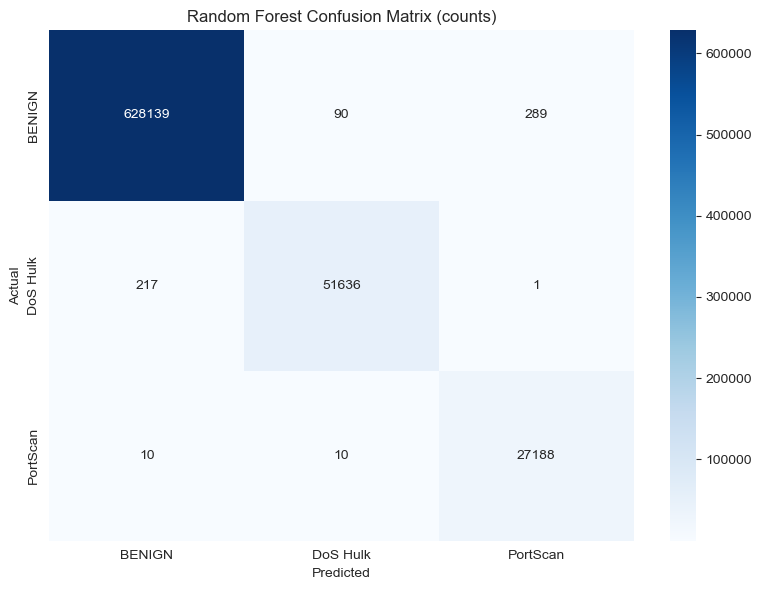

In [25]:
evaluate_model(
    y_true=y_test,
    y_pred=clf.predict(X_test),
    model_name="Random Forest"
)

In [41]:
# Save model + encoders
os.makedirs('models', exist_ok=True)
out_path = 'models/random_forest.joblib'
joblib.dump({
    'model': clf
}, out_path)
print("Saved model to", out_path)

Saved model to models/random_forest.joblib


# CNN-LSTM Baseline

In [42]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder, StandardScaler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [43]:
# STEP 2: Encode labels + scale features (fit scaler on train only)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_balanced.astype(str))
y_test_enc  = le.transform(y_test.astype(str))

print("Classes:", list(le.classes_))
print("Train label counts:", np.bincount(y_train_enc))
print("Test label counts:", np.bincount(y_test_enc))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled  = scaler.transform(X_test)

print("X_train_scaled:", X_train_scaled.shape, "X_test_scaled:", X_test_scaled.shape)

Classes: ['BENIGN', 'DoS Hulk']
Train label counts: [155561 155561]
Test label counts: [209506  17285]
X_train_scaled: (311122, 76) X_test_scaled: (226791, 76)


In [44]:
class NetworkDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Return (C, L) for Conv1d: channels=1, length=n_features
        x = self.X[idx].unsqueeze(0)  # (1, F)
        y = self.y[idx]
        return x, y
    
train_ds = NetworkDataset(X_train_scaled, y_train_enc)
test_ds  = NetworkDataset(X_test_scaled, y_test_enc)

train_loader = DataLoader(train_ds, batch_size=4096, shuffle=True, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=4096, shuffle=False, num_workers=0, pin_memory=True)

n_features = X_train_scaled.shape[1]
print("n_features:", n_features)

n_features: 76


In [45]:
# Define CNN-LSTM model

class CNNLSTM(nn.Module):
    def __init__(self, n_features: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
        )

        # After two pool(2): length becomes roughly n_features / 4
        self.lstm = nn.LSTM(
            input_size=128,      # channels become features per timestep after permute
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )

        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)      # logits (use BCEWithLogitsLoss)
        )

    def forward(self, x):
        # x: (N, 1, F)
        x = self.conv(x)         # (N, 128, L)
        x = x.permute(0, 2, 1)   # (N, L, 128) -> for LSTM
        out, (h, c) = self.lstm(x)
        last = out[:, -1, :]     # (N, 64)
        logits = self.head(last).squeeze(1)  # (N,)
        return logits

model = CNNLSTM(n_features).to(device)
print(model)

CNNLSTM(
  (conv): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 64, batch_first=True)
  (head): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [46]:
from torch.utils.data import random_split

torch.manual_seed(42)

val_frac = 0.1
n_total = len(train_ds)
n_val = int(n_total * val_frac)
n_train = n_total - n_val

train_ds_split, val_ds = random_split(train_ds, [n_train, n_val])

train_loader = DataLoader(train_ds_split, batch_size=4096, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,         batch_size=4096, shuffle=False, num_workers=0, pin_memory=True)

print("Train/Val sizes:", len(train_ds_split), len(val_ds))

Train/Val sizes: 280010 31112


In [47]:
# Train
import copy
import time

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model_to_train, loader):
    model_to_train.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        logits = model_to_train(xb)
        yb = yb.view_as(logits)

        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_loss_and_acc(model_to_eval, loader):
    model_to_eval.eval()
    total_loss = 0.0
    correct = 0
    n = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()

        logits = model_to_eval(xb)
        yb = yb.view_as(logits)

        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        correct += (preds == yb).sum().item()
        n += yb.numel()

    return total_loss / len(loader.dataset), correct / n


# Early stopping settings
patience = 5
min_delta = 1e-4  # required improvement
best_val_loss = float("inf")
best_state = copy.deepcopy(model.state_dict())
patience_left = patience

epochs = 10
start = time.time()

for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader)
    val_loss, val_acc = eval_loss_and_acc(model, val_loader)

    elapsed = time.time() - start
    print(f"Epoch {epoch:02d}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | elapsed={elapsed:.1f}s")

    # Check improvement
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())
        patience_left = patience
    else:
        patience_left -= 1
        if patience_left <= 0:
            print(f"Early stopping triggered. Best val_loss={best_val_loss:.4f}")
            break

# Restore best model
model.load_state_dict(best_state)
print("Restored best model weights (by val_loss).")

Epoch 01/10 | train_loss=0.2407 | val_loss=0.1656 | val_acc=0.9467 | elapsed=8.1s
Epoch 02/10 | train_loss=0.0511 | val_loss=0.0411 | val_acc=0.9842 | elapsed=15.7s
Epoch 03/10 | train_loss=0.0357 | val_loss=0.0681 | val_acc=0.9696 | elapsed=23.3s
Epoch 04/10 | train_loss=0.0373 | val_loss=0.0335 | val_acc=0.9850 | elapsed=30.9s
Epoch 05/10 | train_loss=0.0379 | val_loss=0.0429 | val_acc=0.9822 | elapsed=38.8s
Epoch 06/10 | train_loss=0.0388 | val_loss=0.0447 | val_acc=0.9857 | elapsed=47.3s
Epoch 07/10 | train_loss=0.0335 | val_loss=0.0507 | val_acc=0.9701 | elapsed=55.5s
Epoch 08/10 | train_loss=0.0331 | val_loss=0.0645 | val_acc=0.9600 | elapsed=63.3s
Epoch 09/10 | train_loss=0.0319 | val_loss=0.0406 | val_acc=0.9768 | elapsed=71.3s
Early stopping triggered. Best val_loss=0.0335
Restored best model weights (by val_loss).



=== CNN-LSTM Classification Report ===

              precision    recall  f1-score   support

      BENIGN     0.9997    0.9730    0.9862    209506
    DoS Hulk     0.7531    0.9970    0.8581     17285

    accuracy                         0.9749    226791
   macro avg     0.8764    0.9850    0.9221    226791
weighted avg     0.9810    0.9749    0.9764    226791



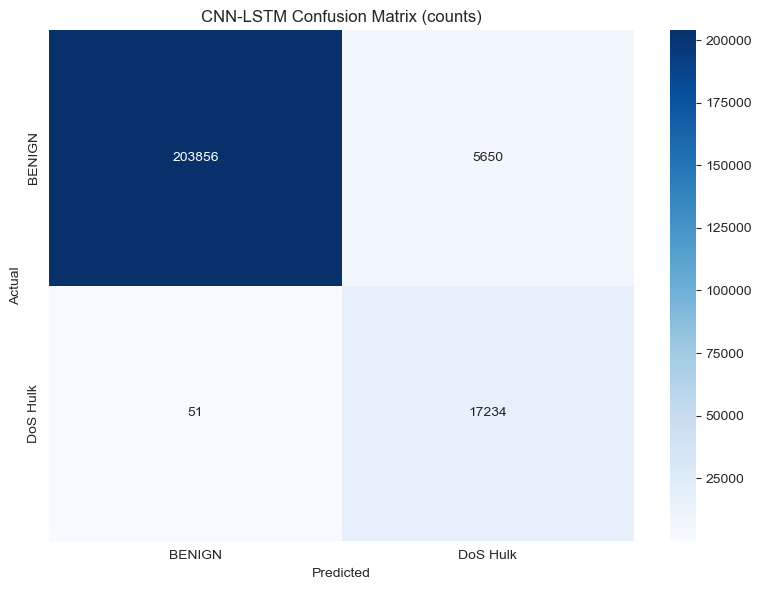

In [48]:
# Classification report + confusion matrix
@torch.no_grad()
def predict_probs(model_to_eval, loader):
    model_to_eval.eval()
    probs_list, y_list = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model_to_eval(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        probs_list.append(probs)
        y_list.append(yb.numpy())
    return np.concatenate(probs_list), np.concatenate(y_list)

probs, yy = predict_probs(model, test_loader)
preds = (probs >= 0.5).astype(int)

yy_labels = le.inverse_transform(yy.astype(int))
pred_labels = le.inverse_transform(preds.astype(int))

evaluate_model(
    y_true=yy_labels,
    y_pred=pred_labels,
    model_name="CNN-LSTM"
)